In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader

from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation import Residual, CombineDataset
from helpers.model.helpers_model import NeuralNet

import warnings
warnings.filterwarnings('ignore') 

from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, roc_curve, roc_auc_score

In [2]:
# Build the four classes 
ratio = 0.75
percent = np.array([0.005, 0.015, 0.005])
size = 6000

res = Residual()
res.build(size, ratio = ratio, per_error = percent)

print('Data Generation Finished')

Data Generation Finished


In [3]:
str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
[final_array, metadata] = read_hdf5(str_ID)
metadata ['ID'] = np.arange(0,final_array.shape[0])

data_set = CombineDataset(metadata,'ID','class',final_array)

print('Reading Data Finished')
data_train, data_test = train_test_split(data_set,train_size=0.9,random_state=42)

batch_size = 50
max_epoch = 70


loader_train = DataLoader(data_train, batch_size = batch_size, shuffle = True, 
                          num_workers = 0, drop_last=True)

loader_test = DataLoader(data_test, batch_size = batch_size, shuffle = True, 
                         num_workers = 0, drop_last=True)

Reading Data Finished


In [4]:
metric = 'accuracy'
netacc = NeuralNet('BasicCNN', 'Adam')
for epoch in range(max_epoch):
    netacc.train(loader_train)
    res = netacc.test(loader_test, metric = metric)
    
print('Finished Training')
epoch = netacc.load_checkpoint()

with torch.no_grad():
    predictions = []
    targets = []
    for data in loader_test:
        images, meta, labels = data
        outputs = netacc.net(images)

        predictions.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        result = netacc.calculate_metrics(np.round(np.array(predictions)), np.array(targets))
    predictions =np.array(predictions); targets = np.array(targets)

epoch: 1.000, accuracy: 0.545
epoch: 2.000, accuracy: 0.621
epoch: 3.000, accuracy: 0.686
epoch: 4.000, accuracy: 0.756
epoch: 5.000, accuracy: 0.798
epoch: 6.000, accuracy: 0.836
epoch: 7.000, accuracy: 0.847
epoch: 8.000, accuracy: 0.856
epoch: 9.000, accuracy: 0.866
epoch: 10.000, accuracy: 0.871
epoch: 11.000, accuracy: 0.877
epoch: 12.000, accuracy: 0.878
epoch: 13.000, accuracy: 0.889
epoch: 15.000, accuracy: 0.890
epoch: 17.000, accuracy: 0.890
epoch: 18.000, accuracy: 0.893
epoch: 20.000, accuracy: 0.897
epoch: 23.000, accuracy: 0.900
epoch: 25.000, accuracy: 0.902
epoch: 26.000, accuracy: 0.906
epoch: 28.000, accuracy: 0.907
epoch: 35.000, accuracy: 0.913
epoch: 37.000, accuracy: 0.914
Finished Training


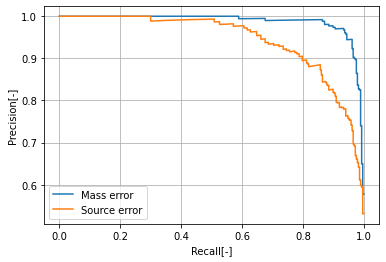

In [5]:
# calculate precision-recall curve
precision0, recall0, thresholds0 = precision_recall_curve(targets[:,0], predictions[:,0])
precision1, recall1, thresholds1 = precision_recall_curve(targets[:,1], predictions[:,1])

plt.plot(recall0, precision0, label='Mass error')
plt.plot(recall1, precision1, label='Source error')
# axis labels
plt.xlabel('Recall[-]')
plt.ylabel('Precision[-]')
# show the legend
plt.legend()
# show the plot

plt.savefig('figures/metric/'+metric+'RecallPrecision.jpeg')
plt.grid()
plt.show()

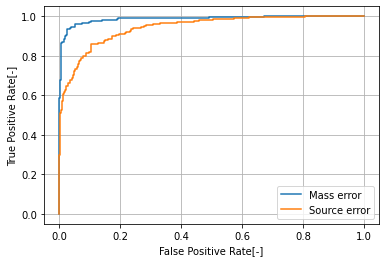

AUC score: 0.913, with accuracy metric


In [6]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets[:,0], predictions[:,0])
lr_fpr, lr_tpr, _ = roc_curve(targets[:,1], predictions[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='Mass error')
plt.plot(lr_fpr, lr_tpr, label='Source error')
# axis labels
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
# show the legend
plt.legend()
plt.grid()
# show the plot
plt.savefig('figures/metric/'+metric+'ROC.jpeg')
plt.show()

txt = "AUC score: {:.3f}, with "+metric+" metric" 
print(txt.format(result['auc']))